# 3. Potential Outcomes and RCTs (Python Implementation)

This notebook implements analysis of potential outcomes and randomized controlled trials using Python.

## Assignment Requirements:
1. **Data Simulation (3 points)**: Simulate dataset with covariates, treatment, and outcome
2. **Estimating Average Treatment Effect (3 points)**: Simple and controlled regression estimates
3. **LASSO and Variable Selection (3 points)**: Use LASSO for covariate selection and ATE estimation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(123)

print("📦 Libraries loaded successfully")

📦 Libraries loaded successfully


## 3.1 Data Simulation (3 points)

We simulate a dataset with n = 1000 individuals with:
- Covariates X₁, X₂, X₃, X₄ (continuous or binary)
- Treatment assignment D ~ Bernoulli(0.5)
- Outcome variable: Y = 2D + 0.5X₁ - 0.3X₂ + 0.2X₃ + ε, where ε ~ N(0,1)

In [2]:
# Set parameters
n = 1000

# Generate covariates
X1 = np.random.normal(2, 1, n)           # Continuous covariate
X2 = np.random.normal(0, 1.5, n)        # Continuous covariate
X3 = np.random.binomial(1, 0.3, n)      # Binary covariate
X4 = np.random.binomial(1, 0.6, n)      # Binary covariate

# Generate treatment assignment
D = np.random.binomial(1, 0.5, n)       # Treatment ~ Bernoulli(0.5)

# Generate error term
epsilon = np.random.normal(0, 1, n)

# Generate outcome variable: Y = 2D + 0.5X1 - 0.3X2 + 0.2X3 + ε
Y = 2*D + 0.5*X1 - 0.3*X2 + 0.2*X3 + epsilon

# Create DataFrame
data = pd.DataFrame({
    'Y': Y,
    'D': D,
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'X4': X4
})

print("📊 Dataset simulated successfully")
print(f"Sample size: {len(data)}")
print(f"Treatment group size: {sum(data['D'])}")
print(f"Control group size: {sum(1 - data['D'])}\n")

# Display first few rows
print("First 5 rows of the dataset:")
data.head()

📊 Dataset simulated successfully
Sample size: 1000
Treatment group size: 514
Control group size: 486

First 5 rows of the dataset:


,Y,D,X1,X2,X3,X4
0,-0.283006,0,0.914369,-1.123241,0,0
1,2.748368,0,2.997345,0.851392,0,1
2,1.751684,1,2.282978,1.077226,0,1
3,2.193469,0,0.493705,-1.499071,1,1
4,3.783708,1,1.421400,0.712347,0,1


### Balance Check (1 point)

We perform a balance check by comparing the means of X₁, X₂, X₃, X₄ across treatment and control groups.

In [3]:
# Balance check: compare means across treatment groups
control_group = data[data['D'] == 0]
treatment_group = data[data['D'] == 1]

balance_results = []
for var in ['X1', 'X2', 'X3', 'X4']:
    control_mean = control_group[var].mean()
    treatment_mean = treatment_group[var].mean()
    difference = treatment_mean - control_mean
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(treatment_group[var], control_group[var])
    
    balance_results.append({
        'Variable': var,
        'Control_Mean': control_mean,
        'Treatment_Mean': treatment_mean,
        'Difference': difference,
        'p_value': p_value
    })

balance_df = pd.DataFrame(balance_results)

print("🔍 Balance Check Results:")
print(balance_df.round(4))
print("\n📈 Balance is good if differences are small and p-values are > 0.05")

🔍 Balance Check Results:
  Variable  Control_Mean  Treatment_Mean  Difference  p_value
0       X1        1.9799          1.9421     -0.0378   0.5510
1       X2        0.0119          0.0132      0.0013   0.9887
2       X3        0.2984          0.3113      0.0129   0.6575
3       X4        0.6399          0.5681     -0.0718   0.0203

📈 Balance is good if differences are small and p-values are > 0.05


## 3.2 Estimating the Average Treatment Effect (3 points)

We estimate the Average Treatment Effect (ATE) using two approaches:
1. Simple regression: Y ~ D
2. Controlled regression: Y ~ D + X₁ + X₂ + X₃ + X₄

In [4]:
# 1. Simple regression: Y ~ D
X_simple = sm.add_constant(data['D'])  # Add constant for intercept
simple_model = sm.OLS(data['Y'], X_simple).fit()

print("📊 Simple Regression Results (Y ~ D):")
print(simple_model.summary())

# Extract ATE and standard error
simple_ate = simple_model.params['D']
simple_se = simple_model.bse['D']

print(f"\n🎯 Simple ATE estimate: {simple_ate:.4f}")
print(f"📏 Standard Error: {simple_se:.4f}")

📊 Simple Regression Results (Y ~ D):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     758.7
Date:                Sun, 21 Sep 2025   Prob (F-statistic):          1.10e-124
Time:                        19:27:40   Log-Likelihood:                -1567.9
No. Observations:                1000   AIC:                             3140.
Df Residuals:                     998   BIC:                             3150.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

In [5]:
# 2. Controlled regression: Y ~ D + X1 + X2 + X3 + X4
X_controlled = sm.add_constant(data[['D', 'X1', 'X2', 'X3', 'X4']])
controlled_model = sm.OLS(data['Y'], X_controlled).fit()

print("📊 Controlled Regression Results (Y ~ D + X1 + X2 + X3 + X4):")
print(controlled_model.summary())

# Extract ATE and standard error
controlled_ate = controlled_model.params['D']
controlled_se = controlled_model.bse['D']

print(f"\n🎯 Controlled ATE estimate: {controlled_ate:.4f}")
print(f"📏 Standard Error: {controlled_se:.4f}")

📊 Controlled Regression Results (Y ~ D + X1 + X2 + X3 + X4):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     293.1
Date:                Sun, 21 Sep 2025   Prob (F-statistic):          1.04e-192
Time:                        19:27:40   Log-Likelihood:                -1397.6
No. Observations:                1000   AIC:                             2807.
Df Residuals:                     994   BIC:                             2837.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [6]:
# Compare the two estimates
comparison = pd.DataFrame({
    'Model': ['Simple (Y ~ D)', 'Controlled (Y ~ D + X1 + X2 + X3 + X4)'],
    'ATE_Estimate': [simple_ate, controlled_ate],
    'Standard_Error': [simple_se, controlled_se],
    'R_Squared': [simple_model.rsquared, controlled_model.rsquared]
})

print("📋 Comparison of ATE Estimates:")
print(comparison.round(4))

print("\n🔍 Analysis:")
print(f"• ATE change: {controlled_ate - simple_ate:.4f}")
print(f"• Standard error change: {controlled_se - simple_se:.4f}")
print("• The true ATE is 2.0 (from our data generating process)")
print("• Controlling for covariates should improve precision and reduce bias")

📋 Comparison of ATE Estimates:
                                    Model  ATE_Estimate  Standard_Error  \
0                          Simple (Y ~ D)        2.0247          0.0735   
1  Controlled (Y ~ D + X1 + X2 + X3 + X4)        2.0456          0.0623   

   R_Squared  
0     0.4319  
1     0.5959  

🔍 Analysis:
• ATE change: 0.0209
• Standard error change: -0.0112
• The true ATE is 2.0 (from our data generating process)
• Controlling for covariates should improve precision and reduce bias


## 3.3 LASSO and Variable Selection (3 points)

We use LASSO to select covariates and then re-estimate the ATE with only the selected variables.

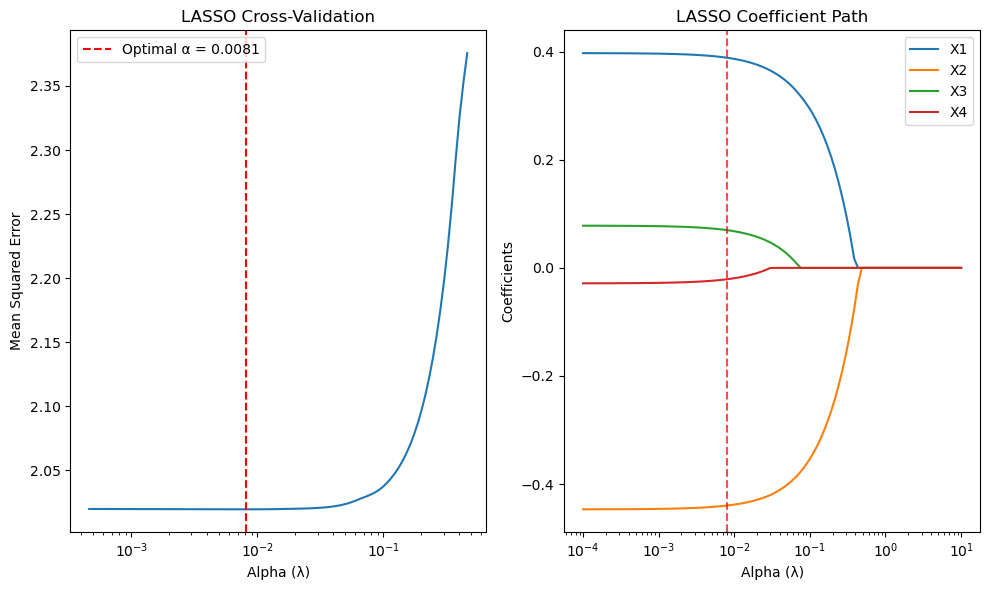

🎯 Optimal alpha (λ): 0.008084


In [7]:
# Prepare data for LASSO (excluding treatment D)
X_matrix = data[['X1', 'X2', 'X3', 'X4']].values
Y_vector = data['Y'].values

# Standardize features for LASSO
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_matrix)

# Fit LASSO model using cross-validation
lasso_cv = LassoCV(cv=10, random_state=123, max_iter=10000)
lasso_cv.fit(X_scaled, Y_vector)

# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1))
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Optimal α = {lasso_cv.alpha_:.4f}')
plt.xlabel('Alpha (λ)')
plt.ylabel('Mean Squared Error')
plt.title('LASSO Cross-Validation')
plt.xscale('log')
plt.legend()

# Plot coefficient path
plt.subplot(1, 2, 2)
alphas = np.logspace(-4, 1, 100)
coefs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, Y_vector)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)
for i in range(4):
    plt.plot(alphas, coefs[:, i], label=f'X{i+1}')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Alpha (λ)')
plt.ylabel('Coefficients')
plt.title('LASSO Coefficient Path')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

print(f"🎯 Optimal alpha (λ): {lasso_cv.alpha_:.6f}")

In [8]:
# Get coefficients and selected variables
lasso_coef = lasso_cv.coef_
variable_names = ['X1', 'X2', 'X3', 'X4']
selected_vars = [var for var, coef in zip(variable_names, lasso_coef) if abs(coef) > 1e-6]

print("📊 LASSO Coefficients:")
for var, coef in zip(variable_names, lasso_coef):
    print(f"{var}: {coef:.6f}")

print(f"\n✅ Variables selected by LASSO: {selected_vars}")

if len(selected_vars) == 0:
    print("⚠️  No variables selected by LASSO at optimal α")
    print("This might indicate that the penalty is too strong or variables are not predictive")

📊 LASSO Coefficients:
X1: 0.388798
X2: -0.439681
X3: 0.069794
X4: -0.020927

✅ Variables selected by LASSO: ['X1', 'X2', 'X3', 'X4']


In [9]:
# Re-estimate ATE with LASSO-selected covariates
if len(selected_vars) > 0:
    # Create design matrix with selected variables
    X_lasso = sm.add_constant(data[['D'] + selected_vars])
    lasso_model = sm.OLS(data['Y'], X_lasso).fit()
    
    print(f"📊 LASSO-Selected Model Results (Y ~ D + {' + '.join(selected_vars)}):")
    print(lasso_model.summary())
    
    # Extract ATE and standard error
    lasso_ate = lasso_model.params['D']
    lasso_se = lasso_model.bse['D']
    
    print(f"\n🎯 LASSO ATE estimate: {lasso_ate:.4f}")
    print(f"📏 Standard Error: {lasso_se:.4f}")
    
else:
    print("⚠️  No variables selected by LASSO - using simple model")
    lasso_ate = simple_ate
    lasso_se = simple_se
    selected_vars_str = "None"

📊 LASSO-Selected Model Results (Y ~ D + X1 + X2 + X3 + X4):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     293.1
Date:                Sun, 21 Sep 2025   Prob (F-statistic):          1.04e-192
Time:                        19:27:41   Log-Likelihood:                -1397.6
No. Observations:                1000   AIC:                             2807.
Df Residuals:                     994   BIC:                             2837.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

📋 Final Comparison of All ATE Estimates:
            Model  ATE_Estimate  Standard_Error  Variables_Used
0          Simple        2.0247          0.0735            None
1      Controlled        2.0456          0.0623  X1, X2, X3, X4
2  LASSO-Selected        2.0456          0.0623  X1, X2, X3, X4

🔍 Discussion:
• True ATE: 2.0
• LASSO helps with variable selection in high-dimensional settings
• In this case, we know X4 has no true effect (coefficient = 0)
• LASSO should ideally select X1, X2, X3 and exclude X4
• Benefits of LASSO: reduces overfitting, improves interpretability
• LASSO may improve precision by removing irrelevant variables


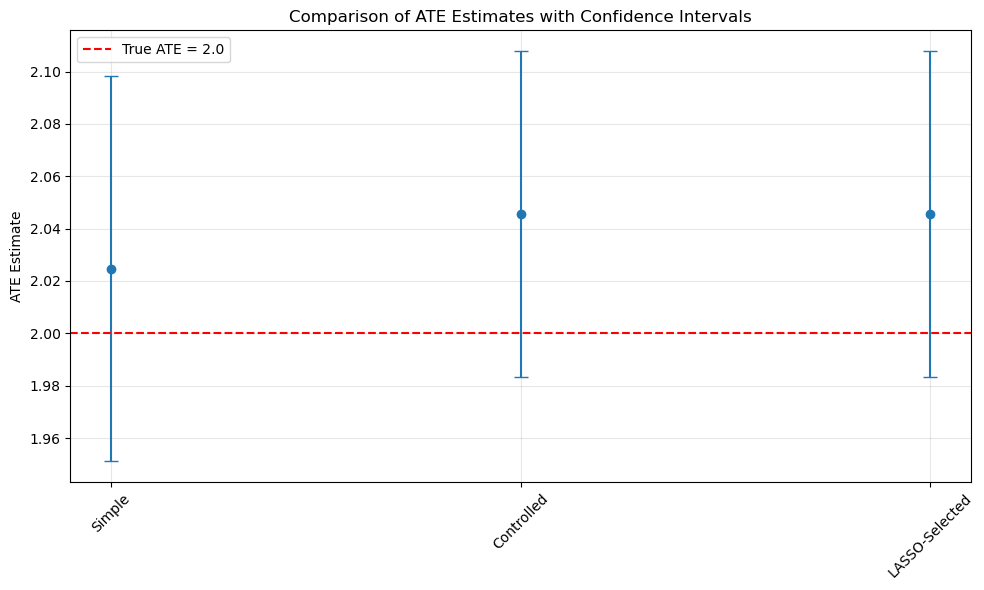

In [10]:
# Final comparison of all three estimates
selected_vars_str = ', '.join(selected_vars) if len(selected_vars) > 0 else "None"

final_comparison = pd.DataFrame({
    'Model': ['Simple', 'Controlled', 'LASSO-Selected'],
    'ATE_Estimate': [simple_ate, controlled_ate, lasso_ate],
    'Standard_Error': [simple_se, controlled_se, lasso_se],
    'Variables_Used': ['None', 'X1, X2, X3, X4', selected_vars_str]
})

print("📋 Final Comparison of All ATE Estimates:")
print(final_comparison.round(4))

print("\n🔍 Discussion:")
print("• True ATE: 2.0")
print("• LASSO helps with variable selection in high-dimensional settings")
print("• In this case, we know X4 has no true effect (coefficient = 0)")
print("• LASSO should ideally select X1, X2, X3 and exclude X4")
print("• Benefits of LASSO: reduces overfitting, improves interpretability")
print("• LASSO may improve precision by removing irrelevant variables")

# Visualization of results
plt.figure(figsize=(10, 6))
models = final_comparison['Model']
estimates = final_comparison['ATE_Estimate']
errors = final_comparison['Standard_Error']

plt.errorbar(range(len(models)), estimates, yerr=errors, fmt='o', capsize=5)
plt.axhline(y=2.0, color='red', linestyle='--', label='True ATE = 2.0')
plt.xticks(range(len(models)), models, rotation=45)
plt.ylabel('ATE Estimate')
plt.title('Comparison of ATE Estimates with Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()